### <p style="padding:10px;background-color:#0077b6;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Ethereum Transaction Fraud Detection Model</p>


## Table of Contents
<p style="margin:20px;font-size:120%">
1. <a href="#introduction">Introduction</a><br>
2. <a href="#imports">Installing and Importing Necessary Libraries and Reading Dataset</a><br>
3. <a href="#auto_ml">Implementing Auto ML _ PyCaret</a><br>
4. <a href="#data-preprocessing">Data Preprocessing</a><br>
5. <a href="#splitting">Splitting Dataset</a><br>
6. <a href="#imbalanced">Solution for Imbalanced Dataset Problem</a><br>
7. <a href="#tuning">Hyper_Parameter Tuning</a><br>
8. <a href="#evaluation">Model Development and Evaluation</a><br>

</p>

### <p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:120%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"><a id="introduction" style="color:white;text-decoration:none">1. Introduction</a></p>
<p style="margin:20px;font-size:120%;text-align:justify">In this project, I will be working with the Ethereum fraud detection dataset to develop a model capable of predicting fraudulent transactions based on the provided data. This endeavor will involve various preprocessing steps and strategies to address the challenge of an imbalanced dataset.</p>






### <p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:120%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"><a id="imports" style="color:white;text-decoration:none">2. Installing and Importing Necessary Libraries and Reading Dataset</a></p>

In [1]:
# /dev/null 2>&1  cause we do not see output when we running
!pip install pycaret > /dev/null 2>&1

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score, confusion_matrix, roc_curve


from catboost import CatBoostClassifier
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report

import pickle

In [3]:
df = pd.read_csv('/kaggle/input/ethereum-frauddetection-dataset/transaction_dataset.csv', index_col=0)
df.sample(3)

,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
867,868,0x153d706d3673f18918f9501405fcb7b6c4df4432,0,0.00,0.00,263.30,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
9426,1765,0xcee56c3d77d814d29b9410c0f74c12781fce03ff,1,0.00,266.74,6106.68,1,16,0,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU
2645,2646,0x45230592db2e92c658c1e67e849f74c3d9f0b971,0,3.77,81753.00,245270.30,3,3,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [4]:
# drop first two columns (Index, Adress)
df = df.iloc[:,2:]

### <p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:120%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"><a id="auto_ml" style="color:white;text-decoration:none">3. Implementing Auto ML _ PyCaret</a></p>
<p style="margin:20px;font-size:120%;text-align:justify">In this part, we will try to use PyCaret as an auto Ml librariey before any preprocessing. This step provides an initial overview of the expected model performance.</p>

In [5]:
from pycaret.classification import *
setup(df,target="FLAG",session_id=20)

,Description,Value
0,Session id,20
1,Target,FLAG
2,Target type,Binary
3,Original data shape,"(9841, 48)"
4,Transformed data shape,"(9841, 48)"
5,Transformed train set shape,"(6888, 48)"
6,Transformed test set shape,"(2953, 48)"
7,Numeric features,45
8,Categorical features,2
9,Rows with missing values,8.7%


In [6]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9936,0.9993,0.9771,0.9940,0.9854,0.9814,0.9814,0.5540
et,Extra Trees Classifier,0.9932,0.9992,0.9692,1.0000,0.9843,0.9800,0.9802,0.2640
xgboost,Extreme Gradient Boosting,0.9932,0.9994,0.9771,0.9920,0.9845,0.9801,0.9801,0.5280
catboost,CatBoost Classifier,0.9932,0.9994,0.9725,0.9966,0.9844,0.9800,0.9801,5.9470
ada,Ada Boost Classifier,0.9923,0.9993,0.9777,0.9875,0.9826,0.9776,0.9777,0.3470
rf,Random Forest Classifier,0.9922,0.9988,0.9679,0.9966,0.9820,0.9770,0.9772,0.3830
gbc,Gradient Boosting Classifier,0.9914,0.9982,0.9705,0.9906,0.9804,0.9749,0.9751,1.1500
dt,Decision Tree Classifier,0.9864,0.9790,0.9659,0.9724,0.9691,0.9603,0.9604,0.0880
knn,K Neighbors Classifier,0.9127,0.9271,0.7509,0.8390,0.7920,0.7371,0.7392,0.0910
ridge,Ridge Classifier,0.8982,0.0000,0.5470,0.9881,0.7036,0.6483,0.6900,0.0630


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=20, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### <p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:120%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"><a id="data-preprocessing" style="color:white;text-decoration:none">4. Data Preprocessing</a></p>
<p style="margin:20px;font-size:120%;text-align:justify">In this section, we will implement various preprocessing techniques to select the most relevant and helpful features for our model. This step is crucial as it significantly impacts the quality and simplicity of our model.</p>


#### 4.1. Some Basic codes

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9841 entries, 0 to 9840
Data columns (total 48 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   FLAG                                                  9841 non-null   int64  
 1   Avg min between sent tnx                              9841 non-null   float64
 2   Avg min between received tnx                          9841 non-null   float64
 3   Time Diff between first and last (Mins)               9841 non-null   float64
 4   Sent tnx                                              9841 non-null   int64  
 5   Received Tnx                                          9841 non-null   int64  
 6   Number of Created Contracts                           9841 non-null   int64  
 7   Unique Received From Addresses                        9841 non-null   int64  
 8   Unique Sent To Addresses                              9841

In [8]:
for col in df:print(f'{col} : {len(df[col].unique())}')

FLAG : 2
Avg min between sent tnx : 5013
Avg min between received tnx : 6223
Time Diff between first and last (Mins) : 7810
Sent tnx : 641
Received Tnx : 727
Number of Created Contracts : 20
Unique Received From Addresses : 256
Unique Sent To Addresses : 258
min value received : 4589
max value received  : 6302
avg val received : 6767
min val sent : 4719
max val sent : 6647
avg val sent : 5854
min value sent to contract : 3
max val sent to contract : 4
avg value sent to contract : 4
total transactions (including tnx to create contract : 897
total Ether sent : 5868
total ether received : 6728
total ether sent contracts : 4
total ether balance : 5717
 Total ERC20 tnxs : 301
 ERC20 total Ether received : 3461
 ERC20 total ether sent : 1416
 ERC20 total Ether sent contract : 30
 ERC20 uniq sent addr : 108
 ERC20 uniq rec addr : 148
 ERC20 uniq sent addr.1 : 5
 ERC20 uniq rec contract addr : 124
 ERC20 avg time between sent tnx : 2
 ERC20 avg time between rec tnx : 2
 ERC20 avg time between 

In [9]:
df['FLAG'].value_counts()

0    7662
1    2179
Name: FLAG, dtype: int64

In [10]:
df['FLAG'].value_counts(normalize=True)


0    0.778579
1    0.221421
Name: FLAG, dtype: float64

#### 4.2. Visualization

In [11]:
value_counts = df['FLAG'].value_counts()
# Create the pie chart
fig = px.pie(values=value_counts, 
             names=value_counts.index,
             title='Distribution of FLAG Categories',
             hole=0.2)

# Update the colors for colorblind accessibility
colors = ['#56B4E9', '#009E73']  

# Update the layout to make it more attractive and accessible
fig.update_layout(font=dict(family="Arial, sans-serif", size=12, color='RebeccaPurple'),
                  paper_bgcolor='white',
                  plot_bgcolor='LightSteelBlue',
                  showlegend=True,
                  title_x=0.5,  # Center the title
                  title_y=0.95,  # Adjust the title position
                  width=800,  # Set the width
                  height=600,  # Set the height
                  )

# Update the color of the plots
fig.update_traces(marker=dict(colors=colors))

# Show the plot
fig.show()

#### 4.3. Dropping categorical columns

In [12]:
df.isnull().sum()

FLAG                                                      0
Avg min between sent tnx                                  0
Avg min between received tnx                              0
Time Diff between first and last (Mins)                   0
Sent tnx                                                  0
Received Tnx                                              0
Number of Created Contracts                               0
Unique Received From Addresses                            0
Unique Sent To Addresses                                  0
min value received                                        0
max value received                                        0
avg val received                                          0
min val sent                                              0
max val sent                                              0
avg val sent                                              0
min value sent to contract                                0
max val sent to contract                

In [13]:
# Turn object variables into 'category' dtype for more computation efficiency
categories = df.select_dtypes('O').columns.astype('category')
df[categories]

,ERC20 most sent token type,ERC20_most_rec_token_type
0,Cofoundit,Numeraire
1,Livepeer Token,Livepeer Token
2,None,XENON
3,Raiden,XENON
4,StatusNetwork,EOS
...,...,...
9836,,GSENetwork
9837,,Blockwell say NOTSAFU
9838,,Free BOB Tokens - BobsRepair.com
9839,NaN,NaN


In [14]:
# Drop the two categorical features
df.drop(df[categories], axis=1, inplace=True)

#### 4.4. Handleing Missing values

In [15]:
# Replace missings of numerical variables with median
df.fillna(df.median(), inplace=True)

In [16]:
df.isnull().sum()

FLAG                                                    0
Avg min between sent tnx                                0
Avg min between received tnx                            0
Time Diff between first and last (Mins)                 0
Sent tnx                                                0
Received Tnx                                            0
Number of Created Contracts                             0
Unique Received From Addresses                          0
Unique Sent To Addresses                                0
min value received                                      0
max value received                                      0
avg val received                                        0
min val sent                                            0
max val sent                                            0
avg val sent                                            0
min value sent to contract                              0
max val sent to contract                                0
avg value sent

#### 4.5. Dropping columns with 0 variance

In [17]:
# Filtering the features with 0 variance
no_var = df.var() == 0
df.var()[no_var]

 ERC20 avg time between sent tnx        0.0
 ERC20 avg time between rec tnx         0.0
 ERC20 avg time between rec 2 tnx       0.0
 ERC20 avg time between contract tnx    0.0
 ERC20 min val sent contract            0.0
 ERC20 max val sent contract            0.0
 ERC20 avg val sent contract            0.0
dtype: float64

In [18]:
# Drop features with 0 variance --- these features will not help in the performance of the model
df.drop(df.var()[no_var].index, axis = 1, inplace = True)
print(df.var())

FLAG                                                    1.724110e-01
Avg min between sent tnx                                4.616718e+08
Avg min between received tnx                            5.327656e+08
Time Diff between first and last (Mins)                 1.042889e+11
Sent tnx                                                5.733918e+05
Received Tnx                                            8.851734e+05
Number of Created Contracts                             2.000685e+04
Unique Received From Addresses                          8.917457e+04
Unique Sent To Addresses                                6.960121e+04
min value received                                      1.062298e+05
max value received                                      1.692294e+08
avg val received                                        8.323238e+06
min val sent                                            1.921264e+04
max val sent                                            4.394646e+07
avg val sent                      

#### 4.6. Checking correlation 

In this section, we will focus on identifying and dropping columns based on their correlation metrics. Specifically, we will remove columns that exhibit either:

* Low correlation with our target column.
* High correlation with other columns, in which case we will retain only one of these highly correlated columns.


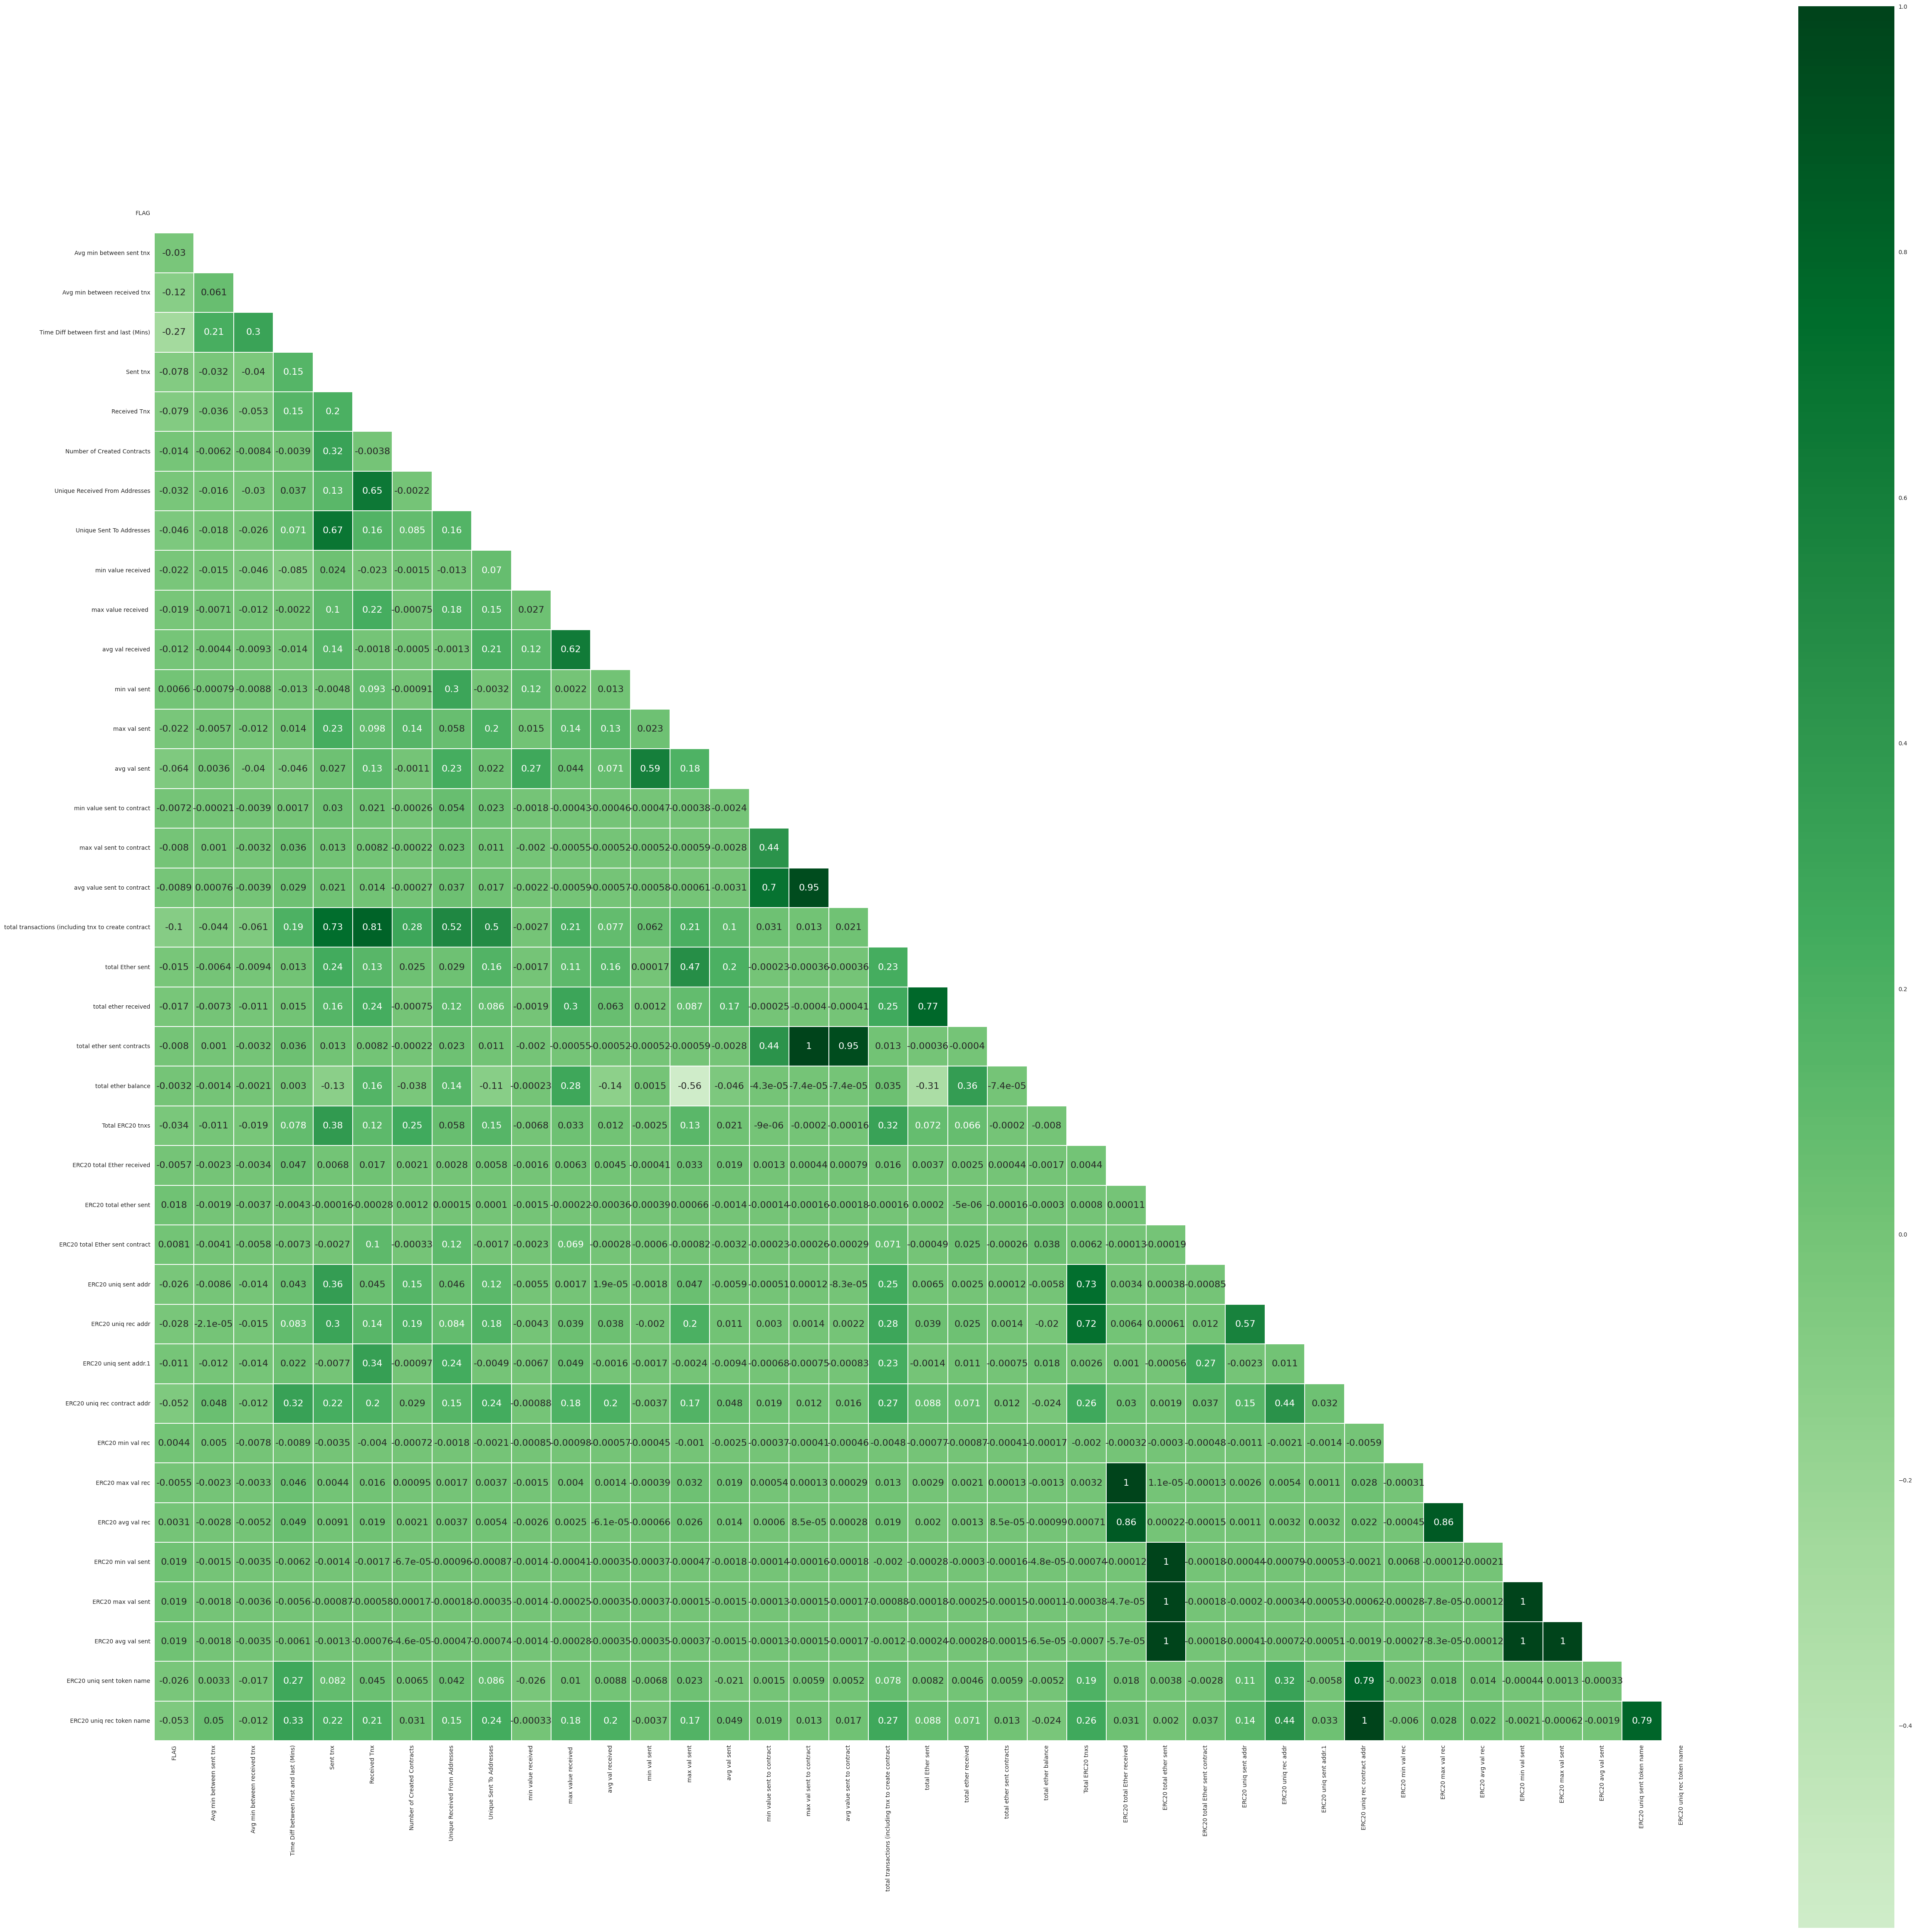

In [19]:
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(60,60))
    sns.heatmap(corr,  mask=mask, annot=True, cmap='Greens', center=0, linewidths=0.1, square=True,annot_kws={"size": 16})

In [20]:
soretd_corr=corr.sort_values(by=['FLAG'],key=abs)
soretd_corr

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 uniq sent token name,ERC20 uniq rec token name
ERC20 avg val rec,0.003132,-0.002829,-0.005241,0.049160,0.009104,0.019382,0.002096,0.003741,0.005412,-0.002610,...,0.003207,0.021501,-0.000455,0.859766,1.000000,-0.000205,-0.000117,-0.000123,0.013764,0.022273
total ether balance,-0.003229,-0.001425,-0.002149,0.002955,-0.127211,0.158146,-0.037902,0.144949,-0.113428,-0.000233,...,0.018368,-0.023787,-0.000170,-0.001251,-0.000991,-0.000048,-0.000112,-0.000065,-0.005164,-0.023809
ERC20 min val rec,0.004434,0.004998,-0.007794,-0.008921,-0.003480,-0.004043,-0.000724,-0.001784,-0.002093,-0.000847,...,-0.001367,-0.005930,1.000000,-0.000311,-0.000455,0.006815,-0.000280,-0.000265,-0.002288,-0.006013
ERC20 max val rec,-0.005510,-0.002260,-0.003326,0.046278,0.004445,0.015522,0.000946,0.001691,0.003696,-0.001528,...,0.001051,0.027598,-0.000311,1.000000,0.859766,-0.000121,-0.000078,-0.000083,0.017746,0.028497
ERC20 total Ether received,-0.005711,-0.002339,-0.003430,0.046570,0.006840,0.016648,0.002099,0.002832,0.005809,-0.001580,...,0.001031,0.030039,-0.000322,0.999967,0.859823,-0.000125,-0.000047,-0.000057,0.018349,0.030934
min val sent,0.006626,-0.000789,-0.008761,-0.013107,-0.004846,0.093448,-0.000913,0.296240,-0.003166,0.117682,...,-0.001735,-0.003749,-0.000446,-0.000393,-0.000663,-0.000369,-0.000366,-0.000353,-0.006785,-0.003728
min value sent to contract,-0.007213,-0.000210,-0.003916,0.001734,0.029529,0.020645,-0.000261,0.053946,0.023183,-0.001820,...,-0.000678,0.018886,-0.000372,0.000541,0.000598,-0.000144,-0.000134,-0.000134,0.001533,0.019304
max val sent to contract,-0.007988,0.001044,-0.003230,0.036162,0.013263,0.008243,-0.000225,0.023258,0.010926,-0.002015,...,-0.000750,0.012325,-0.000412,0.000133,0.000085,-0.000160,-0.000155,-0.000151,0.005911,0.012685
total ether sent contracts,-0.007988,0.001044,-0.003230,0.036162,0.013263,0.008243,-0.000225,0.023258,0.010926,-0.002015,...,-0.000750,0.012325,-0.000412,0.000133,0.000085,-0.000160,-0.000155,-0.000151,0.005911,0.012685
ERC20 total Ether sent contract,0.008127,-0.004101,-0.005813,-0.007337,-0.002652,0.104939,-0.000334,0.116755,-0.001697,-0.002331,...,0.274658,0.037021,-0.000477,-0.000125,-0.000154,-0.000184,-0.000183,-0.000177,-0.002817,0.036892


Below is a list of columns that we intend to drop, along with the reasons for their removal:

* total transactions (including tnx to create contract): Drop due to a high correlation with other features (like Sent tnx and Received Tnx), indicating redundancy.
* total ether sent contracts: Drop due to its high correlation with max val sent to contract and avg value sent to contract, suggesting redundancy.
* max val sent to contract: Drop due to its high correlation with total ether sent contracts and avg value sent to contract, indicating redundancy.
* ERC20 avg val rec: Drop due to potential high correlation with other ERC20 related features like ERC20 max val rec, leading to multicollinearity.
* ERC20 max val rec: Drop due to potential high correlation with other ERC20 related features like ERC20 avg val rec, which might lead to multicollinearity.
* ERC20 min val rec: Drop due to potential high correlation with other ERC20 related features, which might cause multicollinearity.
* ERC20 uniq rec contract addr: Drop due to a high correlation with other ERC20 unique address features, indicating redundancy.
* max val sent: Drop due to high correlation with other transaction value features like avg val sent, suggesting redundancy.
* ERC20 avg val sent: Drop due to potential high correlation with other ERC20 transaction value features, leading to multicollinearity.
* ERC20 min val sent: Drop due to potential high correlation with other ERC20 value features, which might cause multicollinearity.
* ERC20 max val sent: Drop due to potential high correlation with other ERC20 value features, leading to multicollinearity.
* Total ERC20 tnxs: Drop due to a high correlation with other ERC20 transaction features, indicating redundancy.
* avg value sent to contract: Drop due to high correlation with total ether sent contracts and max val sent to contract, suggesting redundancy.
* Unique Sent To Addresses: Drop due to a high correlation with other features like Sent tnx, which might cause multicollinearity.
* Unique Received From Addresses: Drop due to a high correlation with Received Tnx, suggesting redundancy and potential multicollinearity.
* total ether received: Drop due to a high correlation with other features like total ether sent, which might cause multicollinearity.
* ERC20 uniq sent token name: Drop due to potential high correlation with other ERC20 unique token features, leading to multicollinearity.
* min value received: Drop due to low correlation with FLAG and potential redundancy with other value received features.
* min val sent: Drop due to low correlation with FLAG and potential redundancy with other value sent features.
* ERC20 uniq rec addr: Drop due to potential high correlation with other ERC20 unique address features, leading to multicollinearity.

In [21]:
drop = ['total transactions (including tnx to create contract',
        'total ether sent contracts', 
        'max val sent to contract',
        ' ERC20 avg val rec',
        ' ERC20 avg val rec',
        ' ERC20 max val rec', 
        ' ERC20 min val rec', 
        ' ERC20 uniq rec contract addr', 
        'max val sent', 
        ' ERC20 avg val sent',
        ' ERC20 min val sent', 
        ' ERC20 max val sent', 
        ' Total ERC20 tnxs', 
        'avg value sent to contract', 
        'Unique Sent To Addresses',
        'Unique Received From Addresses', 
        'total ether received', 
        ' ERC20 uniq sent token name', 
        'min value received', 
        'min val sent', 
        ' ERC20 uniq rec addr' ]
df.drop(drop, axis=1, inplace=True)

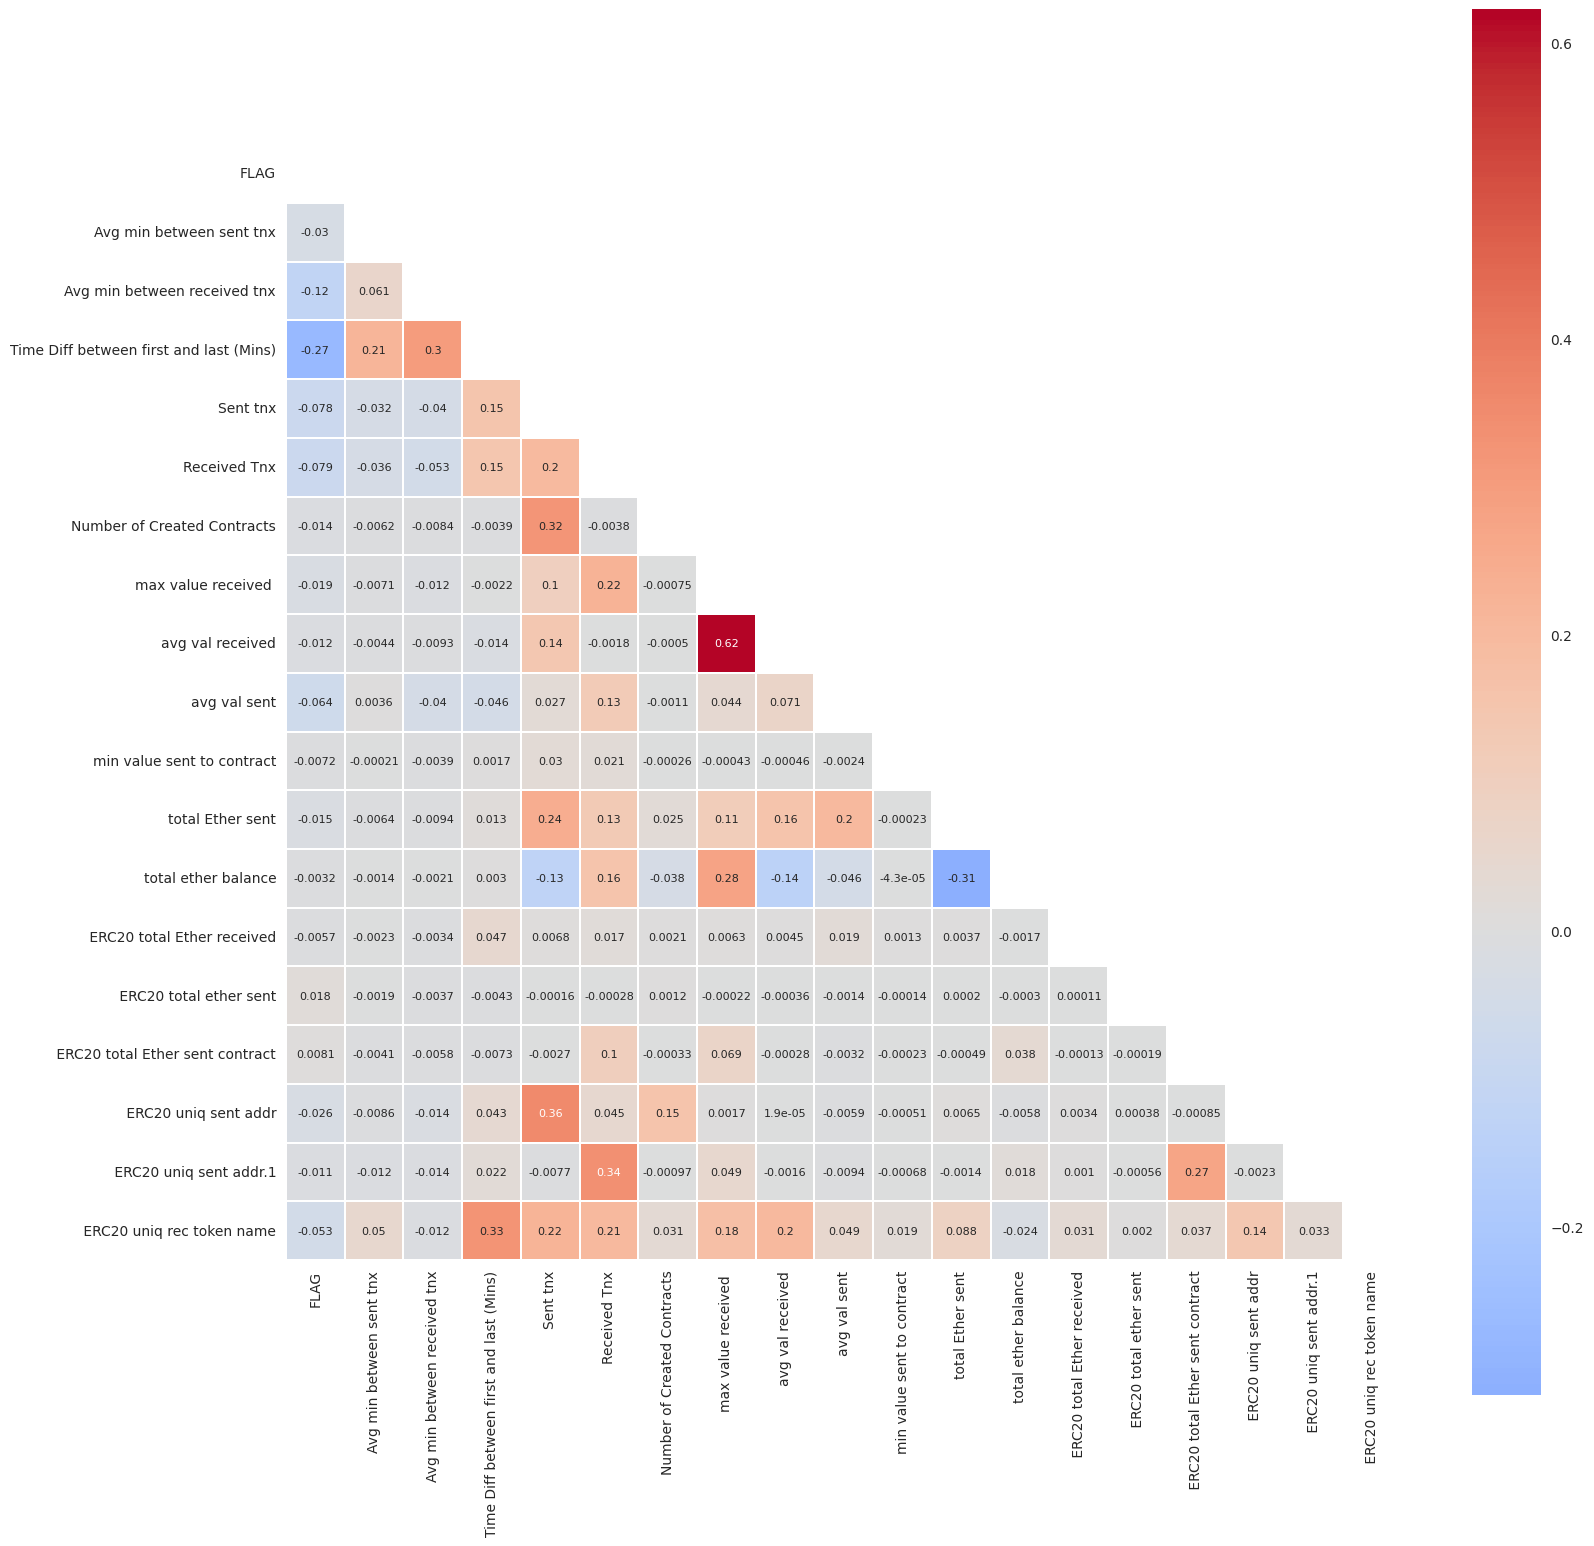

In [22]:
# Recheck the Correlation matrix
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,18))
    sns.heatmap(corr,  mask=mask, annot=True, cmap='coolwarm', center=0, linewidths=0.1, square=True,annot_kws={"size": 8})

In [23]:
columns = df.columns
columns

Index(['FLAG', 'Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'max value received ',
       'avg val received', 'avg val sent', 'min value sent to contract',
       'total Ether sent', 'total ether balance',
       ' ERC20 total Ether received', ' ERC20 total ether sent',
       ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr',
       ' ERC20 uniq sent addr.1', ' ERC20 uniq rec token name'],
      dtype='object')

#### 4.7. Dropping columns presenting a small distribution

In [24]:
# Some features present a small distribution
for i in df.columns[1:]:
    if len(df[i].value_counts()) < 10:
        print(f'The column {i} has the following distribution: \n{df[i].value_counts()}')
        print('======================================')

The column min value sent to contract has the following distribution: 
0.00    9839
0.02       1
0.01       1
Name: min value sent to contract, dtype: int64
The column  ERC20 uniq sent addr.1 has the following distribution: 
0.0    9813
1.0      26
3.0       1
2.0       1
Name:  ERC20 uniq sent addr.1, dtype: int64


In [25]:
drops = ['min value sent to contract', ' ERC20 uniq sent addr.1']
df.drop(drops, axis=1, inplace=True)
print(df.shape)


(9841, 17)


### <p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:120%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"><a id="splitting" style="color:white;text-decoration:none">5. Splitting Dataset</a></p>

In [26]:
y = df.iloc[:, 0]
X = df.iloc[:, 1:]
print(X.shape, y.shape)

(9841, 16) (9841,)


In [27]:
# Split into training (80%) and testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7872, 16) (7872,)
(1969, 16) (1969,)


In [28]:
sc = StandardScaler()
sc_train = sc.fit_transform(X_train)
sc_test = sc.transform(X_test)

### <p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:120%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"><a id="imbalanced" style="color:white;text-decoration:none">6. Solution for Imbalanced Dataset Problem</a></p>
<p style="margin:20px;font-size:120%;text-align:justify"> Up to this point, it's evident that we are dealing with an imbalanced dataset. There are several strategies to address this issue, including undersampling, oversampling, using SMOTE (Synthetic Minority Over-sampling Technique), and adjusting the weights. In this section, we will discuss the SMOTE solution. Although it's not ran here, you are encouraged to explore this technique in your projects. To tackle the challenge of the imbalanced dataset in our current context, we will adjust the weights instead of altering the dataset. This approach aims to achieve a more realistic model representation. </p>

In [29]:
# oversample = SMOTE()
# print(f'Shape of the training before SMOTE: {sc_train.shape, y_train.shape}')

In [30]:
# x_tr_resample, y_tr_resample = oversample.fit_resample(sc_train, y_train)
# print(f'Shape of the training after SMOTE: {x_tr_resample.shape, y_tr_resample.shape}')

In [31]:
# # Target distribution before SMOTE
# non_fraud = 0
# fraud = 0

# for i in y_train:
#     if i == 0:
#         non_fraud +=1
#     else:
#         fraud +=1

# # Target distribution after SMOTE
# no = 0
# yes = 1

# for j in y_tr_resample:
#     if j == 0:
#         no +=1
#     else:
#         yes +=1


# print(f'BEFORE OVERSAMPLING \n \tNon-frauds: {non_fraud} \n \tFauds: {fraud}')
# print(f'AFTER OVERSAMPLING \n \tNon-frauds: {no} \n \tFauds: {yes}')

### <p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:120%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"><a id="tuning" style="color:white;text-decoration:none">7. Hyper_Parameter Tuning</a></p>
<p style="margin:20px;font-size:120%;text-align:justify">The CatBoost classifier is recognized as one of the most powerful and versatile models applicable to a variety of problems. In this context, our chosen approach involves utilizing CatBoost. The initial step in optimizing its performance entails a thorough tuning of its hyperparameters.</p>


In [32]:
# catboost_model = CatBoostClassifier(class_weights=[1, sum(y_train == 0) / sum(y_train == 1)], verbose = False)

# params_grid = {
#     'iterations': [100, 200, 500],  # Number of trees
#     'learning_rate': [0.01, 0.1, 0.5],  # Step size shrinkage used to prevent overfitting
#     'depth': [3, 4, 6],  # Depth of the tree
#     'subsample': [0.5, 0.7, 0.9]  # The subsample ratio of the training instance (bagging)
# }

# grid = GridSearchCV(estimator=catboost_model, param_grid=params_grid, scoring='recall', cv = 10, verbose = 0)

# grid.fit(sc_train, y_train)
# print(f'Best params found for XGBoost are: {grid.best_params_}')
# print(f'Best recall obtained by the best params: {grid.best_score_}')

# Expected output
# Best params found for XGBoost are: {'depth': 4, 'iterations': 100, 'learning_rate': 0.5, 'subsample': 0.9}
# Best recall obtained by the best params: 0.9618636363636364

### <p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:120%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"><a id="evaluation" style="color:white;text-decoration:none">8. Model Development and Evaluation</a></p>
<p style="margin:20px; font-size:120%; text-align:justify;">
  In this section, we will proceed with training the model utilizing the parameters identified in the preceding step. Additionally, we will implement a variety of methods to present the results in a manner that is both clearer and more interpretable:<br>
  <br>- evaluate_model():</b> Captures metrics like accuracy, recall, F1 score for model evaluation.
  <br>- plot_metrics():</b> Plots bar graphs of metrics from evaluate_model().
  <br>- plot_confusion_matrix():</b> Displays the confusion matrix in structured format.
  <br>- plot_roc_curve():</b> Plots Receiver Operating Characteristic (ROC) Curve.
</p>

In [33]:
# Initialize a dictionary to store the metrics
metrics_dict = {}

def evaluate_model(Actual_labels, Predicted_labels, Predicted_probabilities, data_type, metrics_dict):
    # Calculate evaluation metrics
    accuracy = accuracy_score(Actual_labels, Predicted_labels)
    precision = precision_score(Actual_labels, Predicted_labels)
    recall = recall_score(Actual_labels, Predicted_labels)
    f1 = f1_score(Actual_labels, Predicted_labels)
    cross_entropy = log_loss(Actual_labels, Predicted_probabilities)
    roc_auc = roc_auc_score(Actual_labels, Predicted_probabilities)

    # Save the metrics in the dictionary
    metrics_dict[data_type] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Cross-Entropy Loss': cross_entropy,
        'ROC AUC Score': roc_auc
    }

    # Print evaluation metrics
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1)
    print('Cross-Entropy Loss:', cross_entropy)
    print('ROC AUC Score:', roc_auc)
    return metrics_dict

def plot_metrics(metrics_dict):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))    
    colors = ['teal', 'coral']
    for j, metric_name in enumerate(['Accuracy', 'F1 Score', 'Recall', 'ROC AUC Score']):
        ax = axs[j]
        color_index = 0
        for eval_type, metrics in metrics_dict.items():
            value = metrics[metric_name]
            ax.bar(eval_type, value, color=colors[color_index])
            ax.text(eval_type, value, f'{value:.2f}', ha='center', va='bottom')
            color_index = (color_index + 1) % len(colors)
        ax.set_title(f'{metric_name}')
        ax.set_ylim(0, 1)
        ax.set_xlabel('Type')
        ax.set_ylabel(metric_name)
    plt.tight_layout()
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(actual_data, prediction, label):
    conf_matrix = confusion_matrix(actual_data, prediction)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=[f'Actual {label}_0', f'Actual {label}_1'], columns=[f'Predicted {label}_0', f'Predicted {label}_1'])
    print(f'Confusion Matrix for {label}:\n')
    print(conf_matrix_df)
    print('\n')

# Function to plot ROC curve
def plot_roc_curve(y_label, prediction_probability):
    fpr, tpr, thresholds = roc_curve(y_label, prediction_probability)
    roc_auc = roc_auc_score(y_label, prediction_probability)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

Evaluation on Train:

Accuracy: 0.985010162601626
Precision: 0.94225580140313
Recall: 0.993739328400683
F1 Score: 0.9673130193905817
Cross-Entropy Loss: 0.04941477921482291
ROC AUC Score: 0.9989730134479022

-----------------------------------------------------------------
Evaluation on Test:

Accuracy: 0.9659725749111224
Precision: 0.893569844789357
Recall: 0.9549763033175356
F1 Score: 0.9232531500572737
Cross-Entropy Loss: 0.0842270043998869
ROC AUC Score: 0.9947306666013106



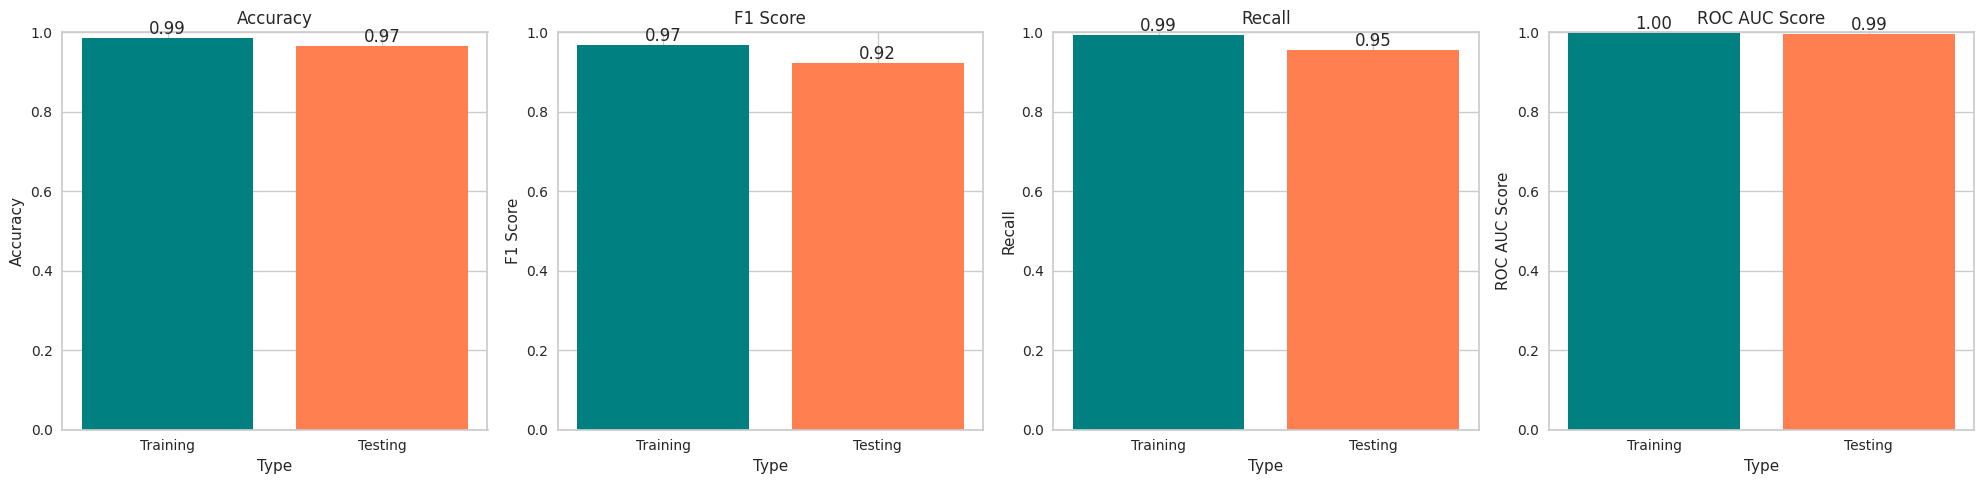


-----------------------------------------------------------------
Confusion Matrix for Training:

                   Predicted Training_0  Predicted Training_1
Actual Training_0                  6008                   107
Actual Training_1                    11                  1746


-----------------------------------------------------------------
Confusion Matrix for Testing:

                  Predicted Testing_0  Predicted Testing_1
Actual Testing_0                 1499                   48
Actual Testing_1                   19                  403


-----------------------------------------------------------------


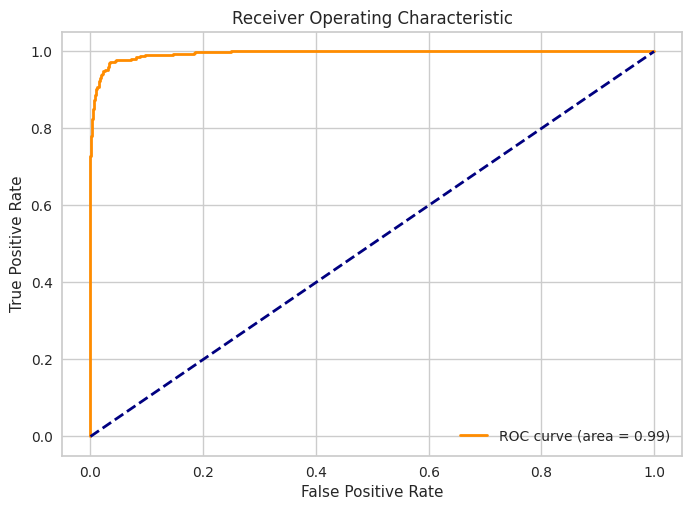

In [34]:
catboost_model = CatBoostClassifier(iterations=100, max_depth=4, learning_rate=0.5,subsample=0.9, 
                                        class_weights=[1, sum(y_train == 0) / sum(y_train == 1)], verbose = False)

# Train the model
catboost_model.fit(sc_train, y_train)

# Predictions
y_train_pred = catboost_model.predict(sc_train)
y_test_pred = catboost_model.predict(sc_test)
y_train_prob = catboost_model.predict_proba(sc_train)[:, 1]
y_test_prob = catboost_model.predict_proba(sc_test)[:, 1]

print("Evaluation on Train:")
print()
metrics_dict = evaluate_model(y_train, y_train_pred, y_train_prob, "Training", {})
print()
print("-----------------------------------------------------------------")
print("Evaluation on Test:")
print()
metrics_dict = evaluate_model(y_test, y_test_pred, y_test_prob, "Testing", metrics_dict)
print()

# Plot metrics
plot_metrics(metrics_dict)
print()
print("-----------------------------------------------------------------")
# Confusion matrices
plot_confusion_matrix(y_train, y_train_pred, 'Training')
print("-----------------------------------------------------------------")
plot_confusion_matrix(y_test, y_test_pred, 'Testing')

# ROC curve
print("-----------------------------------------------------------------")
plot_roc_curve(y_test, y_test_prob)